In [ ]:
- read the paper and add this feature to the presentation 
- that river application paper and others 
- cross sections and my 

# sent to Rolf before bed. take a break now 19.30 

In [2]:
globa_flain_fn = "/media/ljp238/12TBWolf/ARCHIEVE/GFPLAIN/gfplan.vrt"
tile_fn = "/media/ljp238/12TBWolf/RSPROX/OUTPUT_TILES/DEMDOWNX/TILE12/N13E103/N13E103_GEDI03_dtm_EGM.tif"

use this as features labes for classfication

In [5]:
import rasterio
import rasterio.mask
from rasterio.windows import from_bounds
from shapely.geometry import box
import os

def clip_vrt_with_bbox(globa_flain_fn, tile_fn):
    # Definir o nome do arquivo de saída
    tile_fplan_fn = tile_fn.replace('.tif', 'GFPLAIN.tif')
    
    # Abrir o arquivo tile_fn para obter o BBOX
    with rasterio.open(tile_fn) as src:
        bbox = src.bounds  # Obter os limites diretamente
        profile = src.profile  # Armazena as propriedades do arquivo de entrada
    
    # Criar um polígono a partir do BBOX
    bbox_geom = [box(*bbox)]
    
    # Abrir o VRT e recortá-lo
    with rasterio.open(globa_flain_fn) as src:
        out_image, out_transform = rasterio.mask.mask(src, bbox_geom, crop=True)
        out_meta = src.meta.copy()
    
    # Atualizar metadados
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })
    
    # Salvar o arquivo recortado
    with rasterio.open(tile_fplan_fn, "w", **out_meta) as dest:
        dest.write(out_image)
    
    print(f"Arquivo salvo em: {tile_fplan_fn}")
    return tile_fplan_fn


In [26]:
import rasterio
import geopandas as gpd
import numpy as np
from shapely.geometry import shape
from rasterio.features import shapes

def convert_mask_to_gpkg(tile_fplan_fn, output_gpkg):
    # Abrir o arquivo tile_fplan_fn (máscara)
    with rasterio.open(tile_fplan_fn) as src:
        mask_data = src.read(1)  # Lê a primeira banda da máscara
        transform = src.transform  # Obter a transformação do raster
    
    # Criar uma máscara binária onde o valor é 0 (áreas válidas)
    mask_binary = mask_data == 0  # Ajustado para 0 como válida, antes estava como 255
    
    # Extrair formas (polígonos) a partir da máscara binária
    mask_shapes = shapes(mask_binary.astype(np.uint8), mask=mask_binary, transform=transform)
    
    # Convertemos para uma lista de geometrias (polígonos)
    polygons = []
    for geom, _ in mask_shapes:
        polygons.append(shape(geom))  # Transformar a geometria em um objeto Shapely

    # Criar um GeoDataFrame com as geometrias
    gdf = gpd.GeoDataFrame({'geometry': polygons}, crs="EPSG:4326")  # Assuming WGS84 CRS
    
    # Dissolver os polígonos para criar um único recurso
    dissolved_gdf = gdf.dissolve()  # Dissolve into one feature
    
    # Salvar como GeoPackage
    dissolved_gdf.to_file(output_gpkg, driver="GPKG")
    
    print(f"GeoPackage saved to: {output_gpkg}")




In [ ]:
tile_fplan_fn  = clip_vrt_with_bbox(globa_flain_fn, tile_fn)

In [27]:
output_gpkg  = tile_fplan_fn.replace('.tif', '.gpkg')
convert_mask_to_gpkg(tile_fplan_fn, output_gpkg)

GeoPackage saved to: /media/ljp238/12TBWolf/RSPROX/OUTPUT_TILES/DEMDOWNX/TILE12/N13E103/N13E103_GEDI03_dtm_EGMGFPLAIN.gpkg


In [ ]:
# use cartopy to plot basemap at the location to the left, and to the right plot output_gpkg on top of tile_fn

GeoPackage saved to: /media/ljp238/12TBWolf/RSPROX/OUTPUT_TILES/DEMDOWNX/TILE12/N13E103/N13E103_GEDI03_dtm_EGMGFPLAIN.gpkg


Arquivo salvo em: /media/ljp238/12TBWolf/RSPROX/OUTPUT_TILES/DEMDOWNX/TILE12/N13E103/N13E103_GEDI03_dtm_EGMGFPLAIN.tif


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.enums import Resampling


In [11]:
with rasterio.open(tile_fplan_fn) as src:
    d = src.read()

In [ ]:
tile_fn is digital elevation model 
tile_fplan_fn is a mask with np.unique(d) = array([  0, 255], dtype=uint8), where zero is valid values 
i want to plot them by overlaying the mask, but only take the outline where mask is valid 

In [13]:
np.unique(d)

array([  0, 255], dtype=uint8)

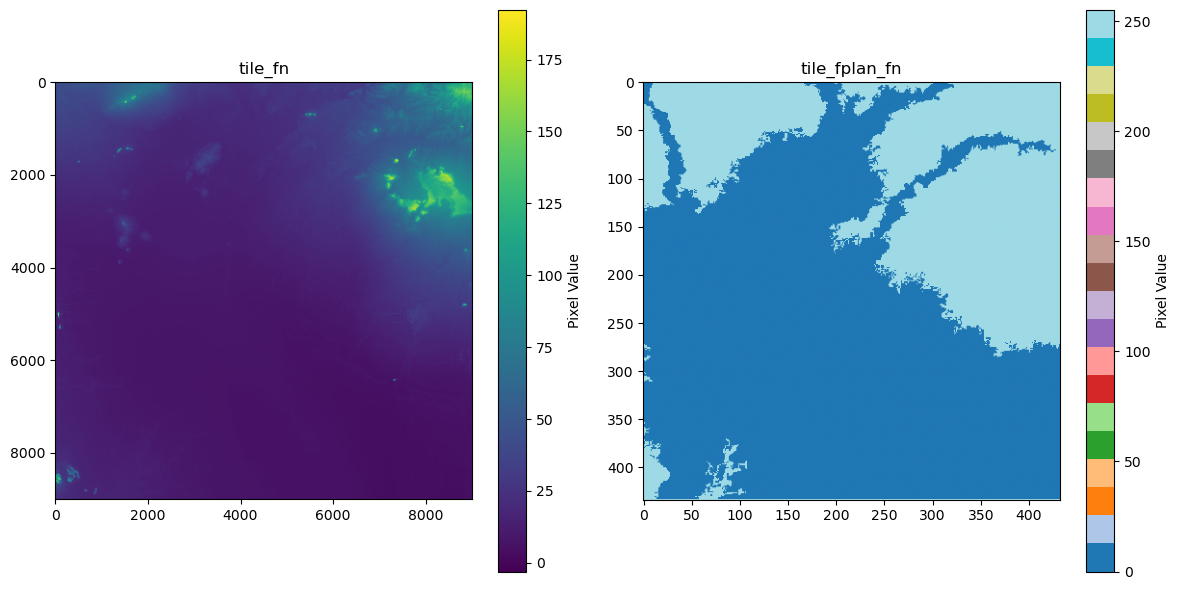

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.enums import Resampling

def plot_rasters_side_by_side(tile_fn, tile_fplan_fn):
    # Função para verificar se os dados são contínuos ou categóricos
    def determine_data_type(data):
        unique_values = np.unique(data)
        return 'categorical' if len(unique_values) < 20 else 'continuous'

    # Abrir o arquivo tile_fn
    with rasterio.open(tile_fn) as src:
        tile_data = src.read(1)  # Lê a primeira banda (assumindo que é uma imagem em escala de cinza)
        tile_meta = src.profile
        tile_type = determine_data_type(tile_data)  # Determina se os dados são contínuos ou categóricos
        
    # Abrir o arquivo tile_fplan_fn
    with rasterio.open(tile_fplan_fn) as src:
        floodplain_data = src.read(1)  # Lê a primeira banda
        floodplain_meta = src.profile
        floodplain_type = determine_data_type(floodplain_data)  # Determina o tipo de dado

    # Plotando as duas imagens lado a lado
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Selecionando colormap baseado no tipo de dado
    cmap_tile = 'viridis' if tile_type == 'continuous' else 'tab20'
    cmap_floodplain = 'viridis' if floodplain_type == 'continuous' else 'tab20'

    # Plotando tile_fn
    im1 = ax1.imshow(tile_data, cmap=cmap_tile)
    ax1.set_title('tile_fn')
    fig.colorbar(im1, ax=ax1, orientation='vertical', label='Pixel Value')

    # Plotando tile_fplan_fn
    im2 = ax2.imshow(floodplain_data, cmap=cmap_floodplain)
    ax2.set_title('tile_fplan_fn')
    fig.colorbar(im2, ax=ax2, orientation='vertical', label='Pixel Value')

    plt.tight_layout()
    plt.show()

# Usar a função com seus arquivos
plot_rasters_side_by_side(tile_fn, tile_fplan_fn)


In [15]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from skimage import measure

def plot_dem_with_mask_outline(tile_fn, tile_fplan_fn):
    # Abrir o arquivo tile_fn (DEM)
    with rasterio.open(tile_fn) as src:
        tile_data = src.read(1)  # Lê a primeira banda (DEM)
        tile_meta = src.profile
    
    # Abrir o arquivo tile_fplan_fn (máscara)
    with rasterio.open(tile_fplan_fn) as src:
        mask_data = src.read(1)  # Lê a primeira banda da máscara
    
    # Criar uma máscara binária onde o valor é 255 (áreas válidas)
    mask_binary = mask_data == 255
    
    # Encontrar os contornos da máscara válida
    contours = measure.find_contours(mask_binary, 0.5)  # 0.5 é a linha de contorno
    
    # Plotando o DEM com a sobreposição do contorno da máscara
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plotando o DEM
    ax.imshow(tile_data, cmap='terrain', alpha=0.7)
    
    # Sobrepondo o contorno da máscara
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], color='red', linewidth=1)  # Plotando o contorno em vermelho
    
    ax.set_title('Digital Elevation Model with Mask Outline')
    plt.colorbar(ax.imshow(tile_data, cmap='terrain', alpha=0.7), ax=ax, label='Elevation (m)')
    
    plt.show()



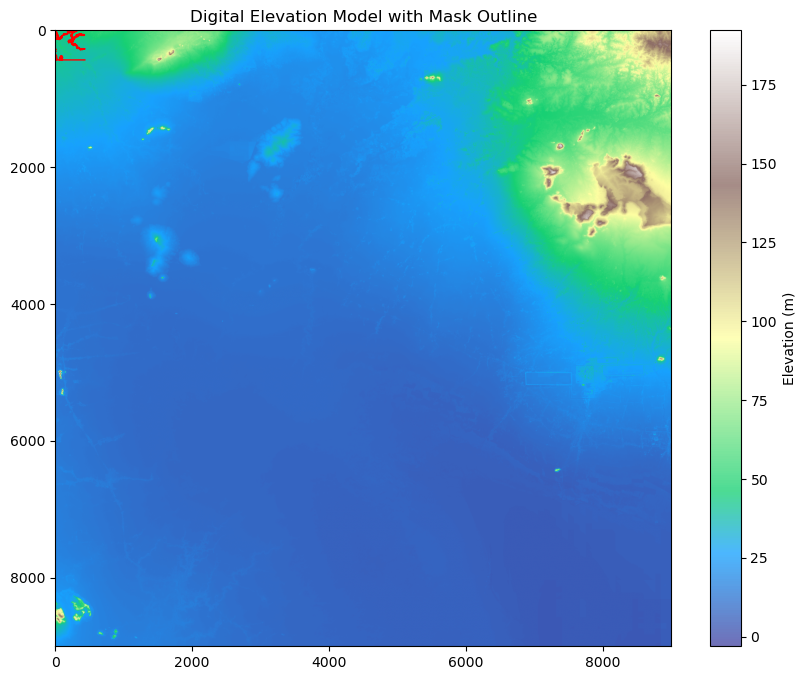

In [16]:
plot_dem_with_mask_outline(tile_fn, tile_fplan_fn)

/home/ljp238/miniconda3/envs/agluon/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


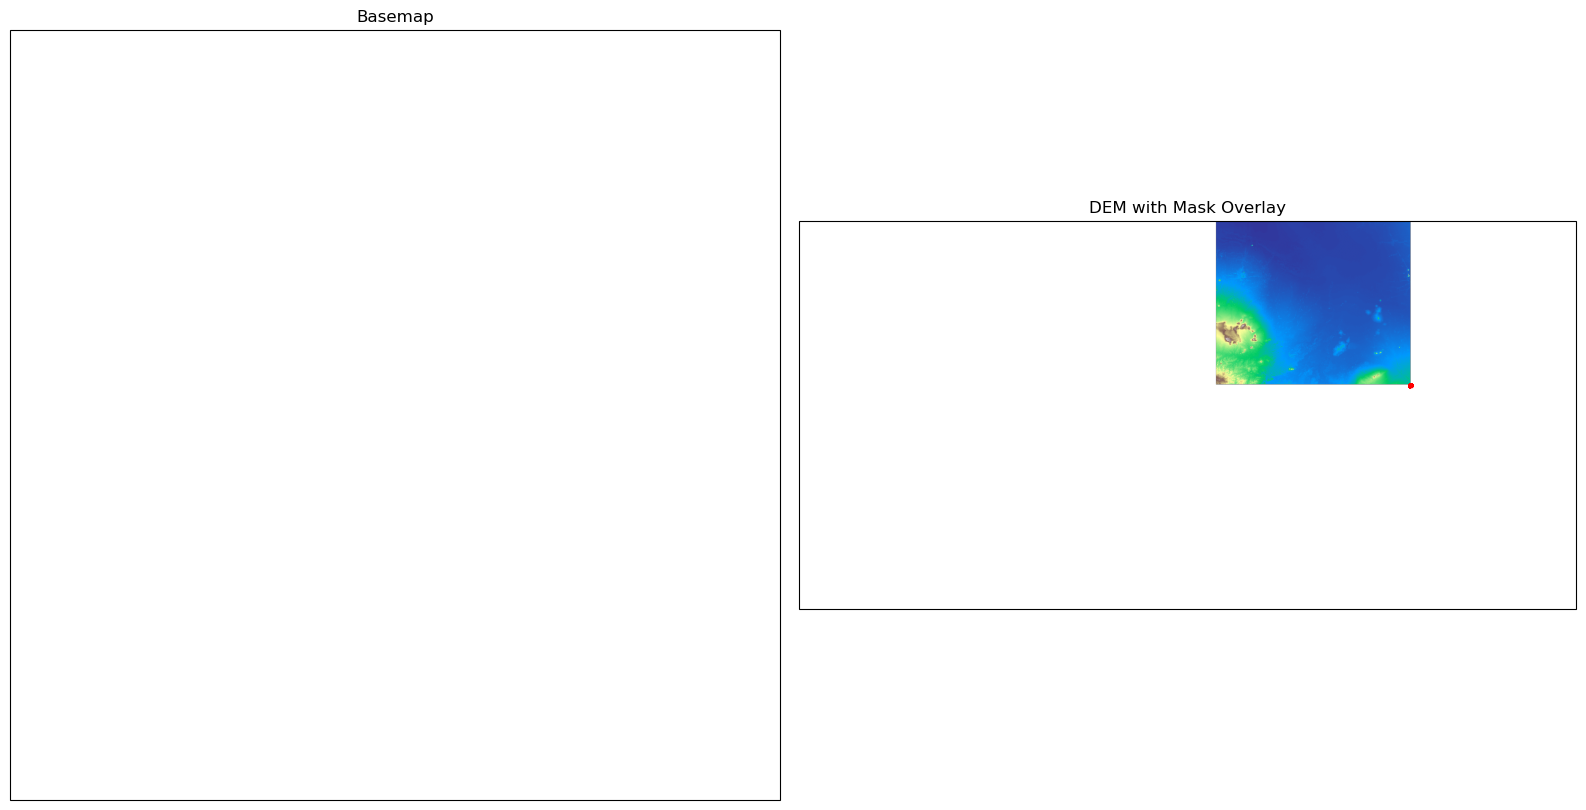

In [29]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import rasterio
import numpy as np
from rasterio.plot import show
from shapely.geometry import Polygon
from cartopy.feature import ShapelyFeature

def plot_basemap_with_overlay(tile_fn, output_gpkg):
    # Abrir o arquivo tile_fn (DEM) para obter as propriedades do raster
    with rasterio.open(tile_fn) as src:
        tile_data = src.read(1)  # Lê a primeira banda (DEM)
        tile_meta = src.profile
        bounds = src.bounds  # Limites do raster (left, bottom, right, top)
    
    # Carregar o GeoDataFrame com o mask dissolvido (depois de convertido em gpkg)
    gdf = gpd.read_file(output_gpkg)
    
    # Criar uma projeção Cartopy para o basemap
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), 
                                   subplot_kw={'projection': ccrs.PlateCarree()})
    
    # --- Plotando o basemap (à esquerda) ---
    # Adicionar um basemap (pode ser um simples mapa de fronteiras)
    ax1.set_extent([bounds[0], bounds[2], bounds[1], bounds[3]], crs=ccrs.PlateCarree())
    ax1.coastlines()
    ax1.set_title('Basemap')

    # --- Plotando a máscara dissolvida sobre o DEM (à direita) ---
    # Plotar o DEM como uma imagem
    ax2.imshow(tile_data, cmap='terrain', origin='upper', extent=bounds)
    ax2.set_title('DEM with Mask Overlay')

    # Plotar o GeoDataFrame (máscara dissolvida) sobre o DEM
    # Adicionar as geometrias dissolvidas ao gráfico
    for _, geometry in gdf.iterrows():
        ax2.add_geometries([geometry['geometry']], crs=ccrs.PlateCarree(), 
                           edgecolor='red', facecolor='none', lw=2)

    plt.tight_layout()
    plt.show()

# Usar a função com seu arquivo de DEM e GeoPackage
plot_basemap_with_overlay(tile_fn, output_gpkg)
